To cluster genes, instead of samples, we need to keep the objects as rows instead of transposing the data. When loading data, do not transpose it but do make sure to eliminate non numeric data from the main matrix and keep the gene and sample labels in variables that later can be used.

# Load Data and set initial objects

In [ ]:
#Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn import metrics

#load data
df_load = pd.read_table('https://raw.githubusercontent.com/PineBiotech/omicslogic/master/CellLines_ExprData_marked.txt',sep='\t',header=(0)) 
labels_list = df_load.loc[[0]] 

#save sample names and clean them
#sample_names = df_load.loc[0] 
sample_names = list(df_load)[1:] 
labels = np.unique(labels_list) 
labels = np.delete(labels, np.where(labels == 'Group')) 

#save gene Ids and clean them
geneids = df_load['id']
geneids = geneids.drop([0]) 

#clean data
data=df_load.drop([0]) 

#will be used later on to add cluster IDs
df_clust = data
df_clust.set_index(['id'], inplace=True)

#data=data.drop(['id'], axis=1) 
datafinal = data.astype(float)


data

,600MPE,AU565,BT474,BT483,BT549,CAMA1,EFM192A,EFM192B,EFM192C,HCC1143,HCC1395,HCC1419,HCC1428,HCC1569,HCC1806,HCC1937,HCC1954,HCC202,HCC3153,HCC70,JIMT1,LY2,MCF10A,MCF10F,MCF12A,MCF7,MDAMB134VI,MDAMB175VII,MDAMB231,MDAMB361,MDAMB453,MX1,SKBR3,SUM1315MO2,SUM149PT,SUM225CWN,SUM229PE,SUM52PE
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ENSG00000000419,5.32,5.3,6.64,5.6,6.61,5.24,6.66,6.62,6.41,5.19,6.16,7.29,4.78,6.14,5.66,5.8,6.2,4.69,6.5,5.49,7.29,5.23,5.63,4.82,5.64,6.07,4.79,6.25,5.19,5.8,4.63,5.98,6.19,4.97,4.15,5.82,6.4,4.67
ENSG00000001036,6.11,4.8,4.47,4.99,6.94,5,5.11,5.42,4.58,4.74,6.03,5.47,4.32,6.16,5.89,5.37,6.01,4.72,5.17,5.96,6.35,5.02,5.31,6.37,5.24,6.29,5.81,4.16,6.56,5.91,5.19,4,5.48,4.14,5.9,5.51,5.14,6.22
ENSG00000001084,5.78,4.01,5.14,5.11,3.63,5.93,4.11,3.68,3.23,5.01,5.81,4.5,5.17,5.61,6.19,5.02,6.79,5.97,4.77,5.85,4.78,4.27,6.8,6.25,4.5,5.08,5.21,4.24,4.12,6,4.16,3.19,4.29,3.95,5.26,6.63,4.38,6.38
ENSG00000001497,4.93,6.16,5.36,5.1,6.16,5.5,6.1,6.88,5.99,6.69,5.03,5.33,6.46,4.99,5.49,5.47,5.95,4.04,4.63,4.97,6.12,4.77,5.31,4.79,5.62,5.11,5.34,4.2,5.47,3.92,5.14,5.95,4.74,4.95,5.26,4.69,6.16,5.11
ENSG00000001617,4.06,7.53,4.7,6.69,3.3,5.39,6.55,6.41,5.26,1.76,3.94,4.74,4.67,2.71,3.33,5.04,5.33,5.5,5.05,5.83,3.86,7.31,5.13,5.15,5.23,5.51,6.76,5.12,1.12,5.49,7.74,1.38,6.81,1.71,4.8,3.8,5.59,5.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000270016,1.26,0,0.27,0.24,0,0.62,0,0,0,0,0.27,0,0,0,0,0.32,0,6.09,0,0.34,0,0,0,0,0,0,0.25,0.15,0,0,0,0,0,0,0.48,0,0,0.72
ENSG00000270149,0,5.49,3.93,5.41,1.98,4.31,5.05,4.7,4.87,3.95,0,3.78,4.47,4.4,2.3,4.79,4.58,3.47,4.72,5.41,5.35,5.26,4.82,4.17,6.01,4.23,3.5,4.85,2.69,3.88,5.46,5.32,4.65,0,2.1,5.66,5.18,5.03
ENSG00000270161,3.68,5.96,4.78,4.83,3.33,4.15,5.36,5.34,5.19,3.86,3.63,4.92,4.64,2.76,4.03,4.19,4.07,4.08,4.21,3.75,2.13,5.16,4.63,4.76,5.88,4.71,4.38,3.17,3.9,3.29,5.13,4.34,3.71,3.82,3.04,3.53,4.35,4


# PCA

PCA will help understand variance for the full dataset. After we perform PCA, we will see clusters in variance that explains well the fiull dataset.

In [ ]:
#first, we are going to explore the data (without transposing as before)
from sklearn.decomposition import PCA

logD = np.log(datafinal+1)
logD.describe()

pca_all = PCA().fit(datafinal)

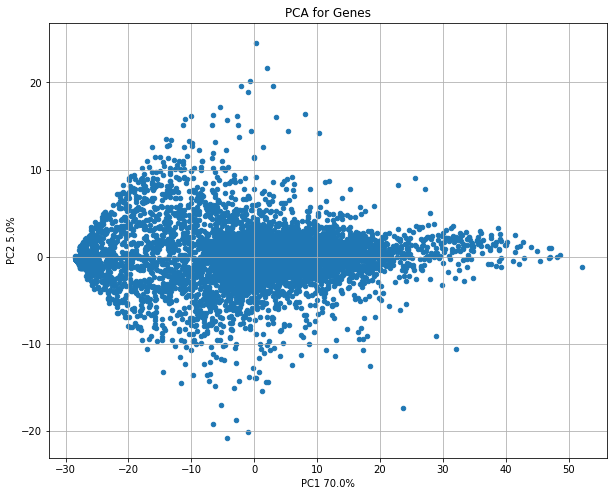

In [ ]:
#prepare a scatterplot of genes based on PC1 and PC2
X_pca = pca_all.transform(datafinal)

d = {'GeneIds':geneids, 'PC1':X_pca[:,0], 'PC2':X_pca[:,1]}
df = pd.DataFrame(d)

df.plot.scatter(x='PC1', 
                y='PC2', 
                figsize=(10,8), 
                title='PCA for Genes',
                sharex=False, 
                grid=True).set(
                xlabel=f'PC1 {round(pca_all.explained_variance_ratio_[0],1)*100}%', 
                ylabel=f'PC2 {round(pca_all.explained_variance_ratio_[1],2)*100}%'
                )

_ = plt.plot()

# Kmeans

In the clustering problem, we are given a training set ${x^{(1)}, ... , x^{(m)}}$, and want to group the data into a few cohesive "clusters." Here, we are given feature vectors for each data point $x^{(i)} \in \mathbb{R}^n$ as usual; but no labels $y^{(i)}$ (making this an unsupervised learning problem). Our goal is to predict $k$ centroids and a label $c^{(i)}$ for each datapoint. The k-means clustering algorithm is as follows:

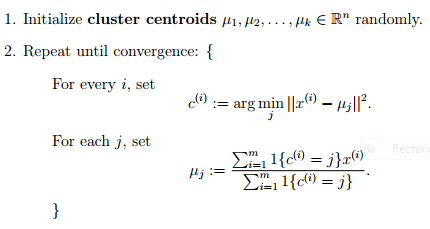

In [ ]:
#load the sklearn cluster library Kmeans 
from sklearn.cluster import KMeans

#set k
k=6

#run kmeans
kmeans_m = KMeans(k).fit(datafinal)

#add kmeans cluster labels to a dataframe
df["Kmeans_6"] = kmeans_m.labels_

#check
#df.head()

Now we can visualize clusters on the PCA scatterplot

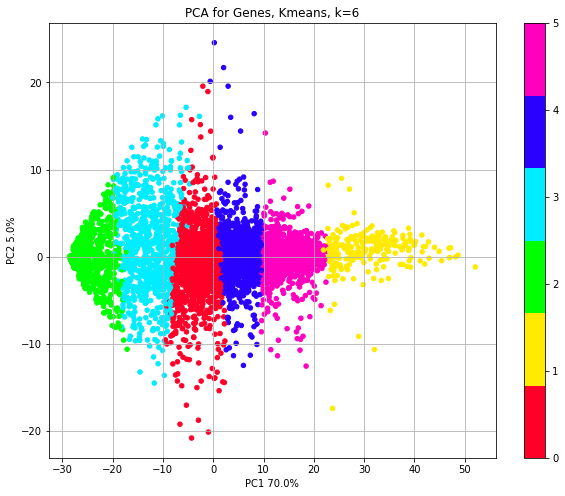

In [ ]:
df.plot.scatter(x='PC1', 
                y='PC2', 
                c=df['Kmeans_6'].astype('category').cat.codes, 
                colormap=plt.cm.get_cmap('gist_rainbow', k), 
                figsize=(10,8),
                title='PCA for Genes, Kmeans, k=%s' % k,
                sharex=False, 
                grid=True).set(
                    xlabel=f'PC1 {round(pca_all.explained_variance_ratio_[0],1)*100}%', 
                    ylabel=f'PC2 {round(pca_all.explained_variance_ratio_[1],2)*100}%'
                    )

_ = plt.plot()

Let's plot intertia for k-means to see how "good" the clustering is. Inertia measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster.
A good model is one with low inertia AND a low number of clusters (K). However, this is a tradeoff because as K increases, inertia decreases. To find the optimal K for a dataset, use the Elbow method; find the point where the decrease in inertia begins to slow. K=3 is the “elbow” of this graph.

In [ ]:
#K-means evaluation inertia
print(kmeans.inertia_)

338571.97375832254


This is a high number for 6 clusters, in the previous clustering exercise, we got 371333.39672714286 for 4 clusters, or approximately the same number for 1 cluster.

Maybe the number of clusters is important, so we can evaluate what number of clusters would reduce the inertia and select the number of clusters based on the "elbow method"

In [ ]:
#create an empty dataframe
inertia_df = pd.DataFrame()

#run a loop between 2 and 20 clusters to compare inertia
for i in range (2,20):
  kmeans_m = KMeans(n_clusters=i).fit(datafinal)
  inertia_df = inertia_df.append({'clust':i,'inertia': kmeans_m.inertia_}, ignore_index=True)

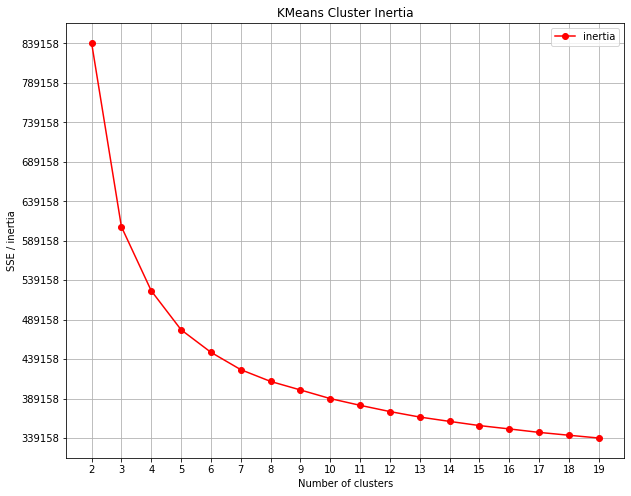

In [ ]:
#plot inertia across cluster numbers
inertia_df.plot('clust', 'inertia', marker='o',
        figsize=(10,8), color = 'r',
        title='KMeans Cluster Inertia',
        sharex=False, 
        grid=True).set(
            ylabel='SSE / inertia',
            xlabel='Number of clusters',
            xticks= np.arange(min(inertia_df.clust), max(inertia_df.clust)+1, 1.0),
            yticks= np.arange(min(inertia_df.inertia), max(inertia_df.inertia)+1, 50000)
        )

_ = plt.plot()

Based on inertia, we can select the number of clusters as 6, however this parameter is not comparable across all types of clustering so to evaluate this further, let's try to use silhoette score which we can calculate for all types of clsutering.

The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [ ]:
#import package
from sklearn.metrics import silhouette_samples, silhouette_score

#create an empty dataframe to store values
df_scores_kmeans = pd.DataFrame()

#for loop to get silhouette score for clusters 2 to 20
for i in range (2,20):
  kmeans = KMeans(n_clusters=i)
  cluster_labels = kmeans.fit_predict(datafinal)
  silhouette_avg = silhouette_score(datafinal, kmeans.labels_)
  df_scores_kmeans = df_scores_kmeans.append({'clust':i,'silhouette_avg': 
                                              silhouette_avg}, ignore_index=True)

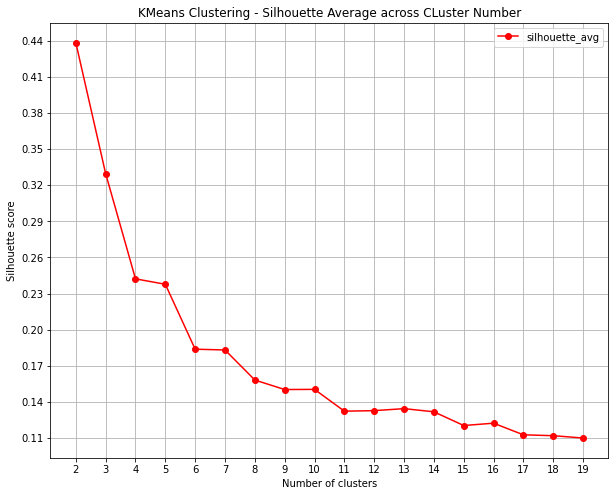

In [ ]:
#plot silhouette_score across cluster numbers
df_scores_kmeans.plot('clust', 'silhouette_avg', marker='o',
        figsize=(10,8), color = 'r',
        title='KMeans Clustering - Silhouette Average across CLuster Number',
        sharex=False, 
        grid=True).set(
            ylabel='Silhouette score',
            xlabel='Number of clusters',
            xticks= np.arange(min(df_scores_kmeans.clust), max(df_scores_kmeans.clust)+1, 1.0),
            yticks= np.arange(min(df_scores_kmeans.silhouette_avg), max(df_scores_kmeans.silhouette_avg)+1, 0.03)
        )

_ = plt.plot()

Based on this score, it looks like **k=8** is a good number of clusters to use

In [ ]:
#set k
k=8

#run Kmeans
kmeans_m = KMeans(k).fit(datafinal)

#add to the dataframe
df["Kmeans_8"] = kmeans_m.labels_

#check
df.head()

,GeneIds,PC1,PC2,Kmeans_6,Kmeans_8
1,ENSG00000000419,6.553436,-0.372788,4,7
2,ENSG00000001036,4.579762,1.339591,4,4
3,ENSG00000001084,1.906375,0.750737,4,4
4,ENSG00000001497,4.376390,0.526701,4,4
5,ENSG00000001617,1.313118,-5.746566,0,4


In [ ]:
print("Silhouette Coefficient for Kmeans with %s clusters: %0.3f"
      % (k, metrics.silhouette_score(datafinal, kmeans_m.labels_)))

Silhouette Coefficient for Kmeans with 8 clusters: 0.159


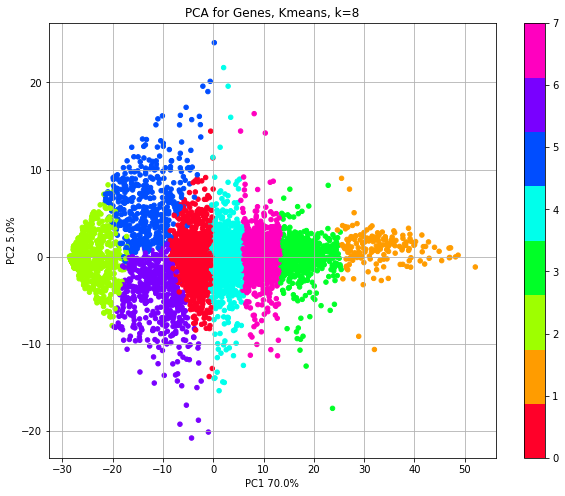

In [ ]:
df.plot.scatter(x='PC1', 
                y='PC2', 
                c=df['Kmeans_8'].astype('category').cat.codes, 
                colormap=plt.cm.get_cmap('gist_rainbow', k), 
                figsize=(10,8), 
                title='PCA for Genes, Kmeans, k=%s' % k,
                sharex=False, 
                grid=True).set(
                    xlabel=f'PC1 {round(pca_all.explained_variance_ratio_[0],1)*100}%', 
                    ylabel=f'PC2 {round(pca_all.explained_variance_ratio_[1],2)*100}%'
                    )

_ = plt.plot()

In [ ]:
for i in range(0, k): 
  print("cluster %s has %s genes" % (i, len(df[df['Kmeans_8'] == i])))

cluster 0 has 1225 genes
cluster 1 has 171 genes
cluster 2 has 740 genes
cluster 3 has 604 genes
cluster 4 has 1895 genes
cluster 5 has 442 genes
cluster 6 has 509 genes
cluster 7 has 1326 genes


In [ ]:
df.head()

,GeneIds,PC1,PC2,Kmeans_6,Kmeans_8
1,ENSG00000000419,6.553436,-0.372788,4,7
2,ENSG00000001036,4.579762,1.339591,4,4
3,ENSG00000001084,1.906375,0.750737,4,4
4,ENSG00000001497,4.376390,0.526701,4,4
5,ENSG00000001617,1.313118,-5.746566,0,4


The number of genes in each cluster is fairly high. It is also likely that some clusters do not represent homogeneous groups, but instead are noisy groups that have a lot of variation. Later on, we will look into how we can check this variation within clusters and be able to understand the meaning of such separation.

Now let's check density based clustering. Out of the 3 available on scikit spectral will take a very long time to perform clustering because of so many objects (n is high). Therefore, we will try DBSCAN and OPTICS. OPTICS is very similar to DBSCAN but we will use the xi method instead of DBSCAN for Optics. For DBSCAN it is important to play around with the epsilon and minimum number of samples in each cluster to optimize for performance and number of clsuters not equal to -1 (noise)

# DBScan and OPTICS

Most clustering method has parameters which can have a major influence on the algorithm in specific ways. For DBSCAN, the parameters ε and minPts are needed. The parameters must be specified by the user. 

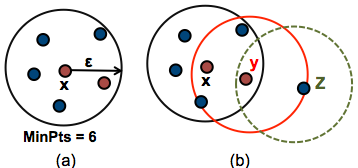

The parameter eps defines the radius of neighborhood around a point x. It’s called called the ϵ-neighborhood of x. The parameter MinPts is the minimum number of neighbors within “eps” radius.

**Minimum points (or samples):** As a rule of thumb, a minimum min_samples can be derived from the number of dimensions D in the data set, as minPts ≥ D + 1. Larger values are usually better for data sets with noise and will yield more significant clusters. As a rule of thumb, minPts = 2·dim can be used, but it may be necessary to choose larger values for very large data, for noisy data or for data that contains many duplicates. In the case of biological data, some reasoning behind selection of minimum cluster size can be considered.

**ε (epsilon):** In general, small values of ε are preferable, and as a rule of thumb only a small fraction of points should be within this distance of each other. Alternatively, an OPTICS plot can be used to choose ε, but then the OPTICS algorithm itself can be used to cluster the data.

Distance function: The choice of distance function is tightly coupled to the choice of ε, and has a major impact on the results. In general, it will be necessary to first identify a reasonable measure of similarity for the data set, before the parameter ε can be chosen. There is no estimation for this parameter, but the distance functions needs to be chosen appropriately for the data set. 

**OPTICS** can be seen as a generalization of DBSCAN that replaces the ε parameter with a maximum value that mostly affects performance. MinPts then essentially becomes the minimum cluster size to find. 

In [ ]:
#load DBScan
from sklearn.cluster import DBSCAN

#run DBSCAN selecting Epsilon and Min_samples according to maximum number of clusters with minimum noise
dbscan_m = DBSCAN(eps=3.7,min_samples=8).fit(datafinal)

#check number of clusters
print(len(set(dbscan_m.labels_)))

8


In [ ]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_DB = len(set(dbscan_m.labels_)) - (1 if -1 in dbscan_m.labels_ else 0)
n_noise_DB = list(dbscan_m.labels_).count(-1)

print('Estimated number of true clusters: %d' % n_clusters_DB)
print('Estimated number of noise points: %d' % n_noise_DB)
print('Silhouette Coefficient: %0.3f'
      % metrics.silhouette_score(datafinal, dbscan_m.labels_))

Estimated number of true clusters: 7
Estimated number of noise points: 4849
Silhouette Coefficient: -0.212


In [ ]:
#OPTICS clustering method - similar to DBSCAN
from sklearn.cluster import OPTICS
optics_m = OPTICS(min_samples=8, max_eps=3.7).fit(datafinal)

print(len(set(optics_m.labels_)))

8


In [ ]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_OP = len(set(optics_m.labels_)) - (1 if -1 in optics_m.labels_ else 0)
n_noise_OP = list(optics_m.labels_).count(-1)

print('Estimated number of true clusters: %d' % n_clusters_OP)
print('Estimated number of noise points: %d' % n_noise_OP)
print('Silhouette Coefficient: %0.3f'
      % metrics.silhouette_score(datafinal, optics_m.labels_))

Estimated number of true clusters: 7
Estimated number of noise points: 5064
Silhouette Coefficient: -0.117


In [ ]:
d = {'GeneIds':geneids, 'Kmeans':kmeans_m.labels_, 'DBScan':dbscan_m.labels_, 'OPTICS':optics_m.labels_, 'PC1':X_pca[:,0], 'PC2':X_pca[:,1]}
df = pd.DataFrame(d)

#check
df.head()

,GeneIds,Kmeans,DBScan,OPTICS,PC1,PC2
1,ENSG00000000419,7,-1,-1,6.553436,-0.372788
2,ENSG00000001036,4,-1,-1,4.579762,1.339591
3,ENSG00000001084,4,-1,-1,1.906375,0.750737
4,ENSG00000001497,4,0,-1,4.376390,0.526701
5,ENSG00000001617,4,-1,-1,1.313118,-5.746566


Let us now check how many genes are in each cluster

In [ ]:
print("DBSCAN clustering results show a total of %s clusters:" % n_clusters_DB)
for i in range(-1, n_clusters_DB): 
  print("cluster %s has %s genes" % (i, len(df[df['DBScan'] == i])))

print("\nOPTICS clustering results show a total of %s clusters:" % n_clusters_OP)
for i in range(-1, n_clusters_OP): 
  print("cluster %s has %s genes" % (i, len(df[df['OPTICS'] == i])))

DBSCAN clustering results show a total of 7 clusters:
cluster -1 has 4849 genes
cluster 0 has 1736 genes
cluster 1 has 233 genes
cluster 2 has 53 genes
cluster 3 has 10 genes
cluster 4 has 7 genes
cluster 5 has 16 genes
cluster 6 has 8 genes

OPTICS clustering results show a total of 7 clusters:
cluster -1 has 5064 genes
cluster 0 has 1734 genes
cluster 1 has 11 genes
cluster 2 has 10 genes
cluster 3 has 13 genes
cluster 4 has 12 genes
cluster 5 has 52 genes
cluster 6 has 16 genes


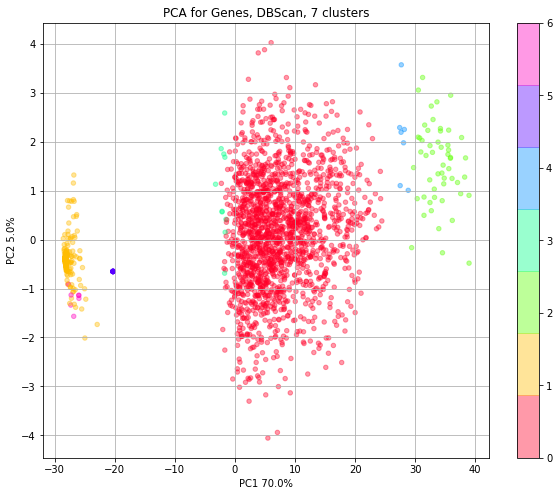

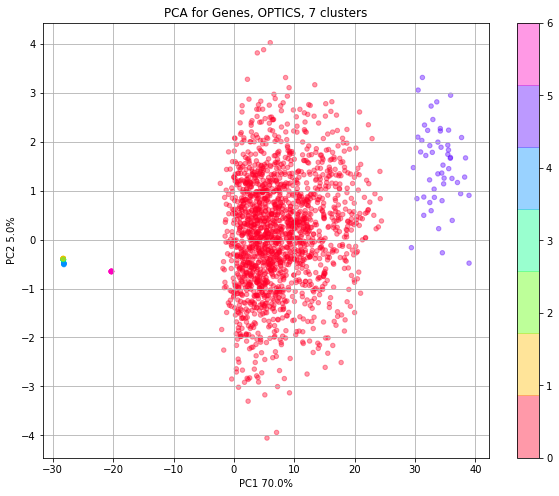

In [ ]:
#draw DBScan clusters on teh PCA scatterplot
df2 = df[(df['DBScan'] != -1)]
df2.plot.scatter(x='PC1', 
                y='PC2', 
                c=df2['DBScan'], 
                colormap=plt.cm.get_cmap('gist_rainbow', n_clusters_DB), 
                figsize=(10,8),
                alpha=0.4,
                title='PCA for Genes, DBScan, %s clusters' % n_clusters_DB,
                sharex=False, 
                grid=True).set(
                    xlabel=f'PC1 {round(pca_all.explained_variance_ratio_[0],1)*100}%', 
                    ylabel=f'PC2 {round(pca_all.explained_variance_ratio_[1],2)*100}%'
                    )

_ = plt.plot()

#draw OPTICS clusters on teh PCA scatterplot
df3 = df[(df['OPTICS'] != -1)]
df3.plot.scatter(x='PC1', 
                y='PC2', 
                c=df3['OPTICS'], 
                colormap=plt.cm.get_cmap('gist_rainbow', n_clusters_OP), 
                alpha=0.4,
                figsize=(10,8),
                title='PCA for Genes, OPTICS, %s clusters' % n_clusters_OP,
                sharex=False, 
                grid=True).set(
                    xlabel=f'PC1 {round(pca_all.explained_variance_ratio_[0],1)*100}%', 
                    ylabel=f'PC2 {round(pca_all.explained_variance_ratio_[1],2)*100}%'
                    )

_ = plt.plot()

# Prepare a dataset with cluster information

**Create a new dataframe**

Create a new dataframe, which contains Cluster Groups from cluster types and coressponding genes expression among samples

In [ ]:
df_clust["Kmeans"] = kmeans_m.labels_
df_clust["DBScan"] = dbscan_m.labels_
df_clust["OPTICS"] = optics_m.labels_

#df_clust.head()

**Create a dataframe for specific cluster**

Next to visulalize which cluster genes much better (i.e. A clusters containing genes having similar expression patterns among samples). Thus, Here, first, we can extract gene expression data for specific cluster. For instance, here, we will obtain data for cluster from each clustering type.

**Note: **you can look at each cluster one by one

In [ ]:
df_DBScan = df_clust.drop(['Kmeans',  'OPTICS'], axis=1)
df_DBScan = df_DBScan.astype(float)

df_Optics = df_clust.drop(['Kmeans',  'DBScan' ], axis=1)
df_Optics = df_Optics.astype(float)

df_Kmeans = df_clust.drop(['DBScan',  'OPTICS' ], axis=1)
df_Kmeans = df_Optics.astype(float)

for DBScan cluster 0, the number of genes is 1736
for DBScan cluster 1, the number of genes is 233
for DBScan cluster 2, the number of genes is 53
for DBScan cluster 3, the number of genes is 10
for DBScan cluster 4, the number of genes is 7
for DBScan cluster 5, the number of genes is 16
for DBScan cluster 6, the number of genes is 8


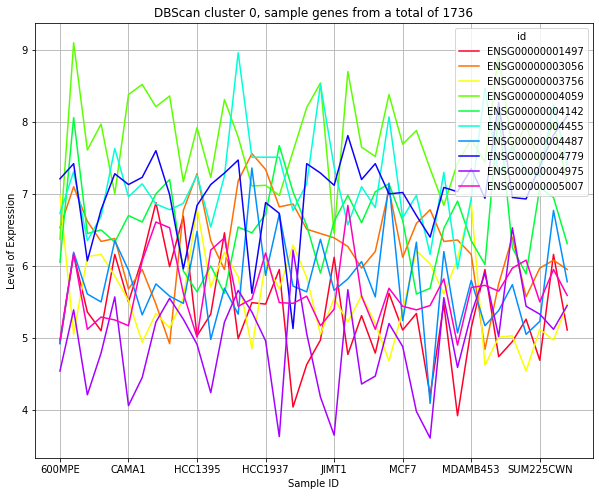

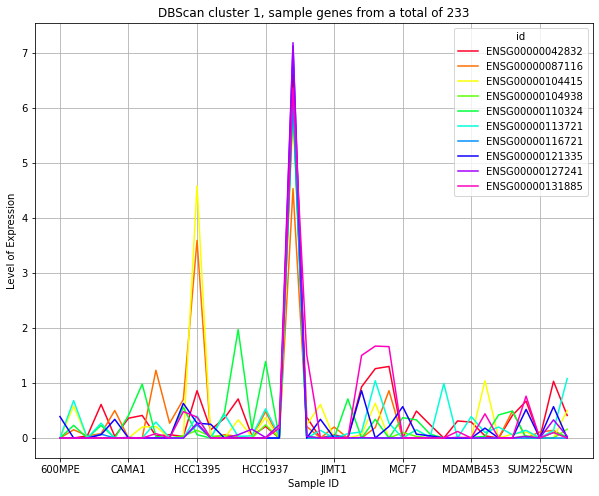

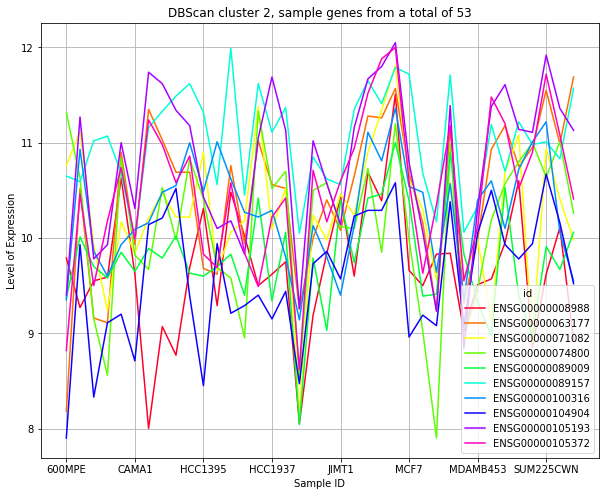

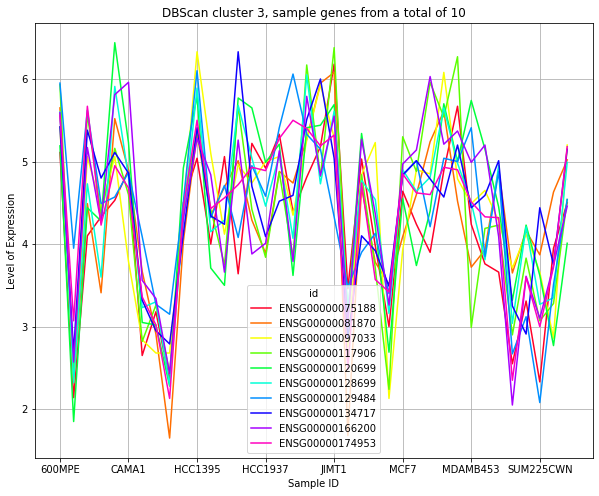

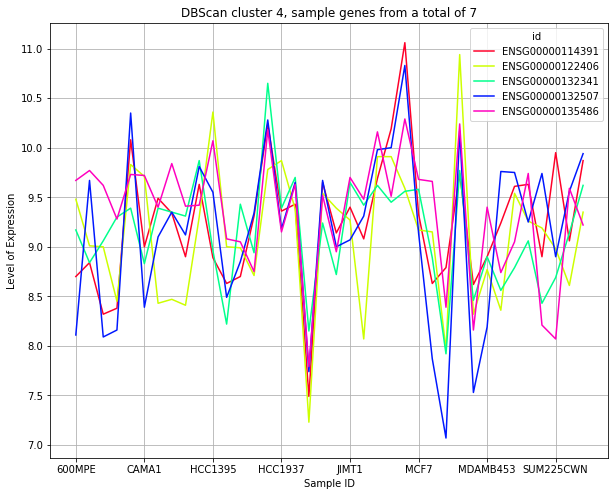

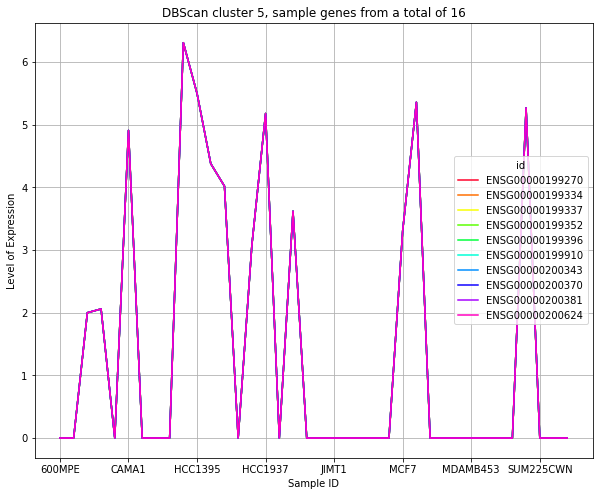

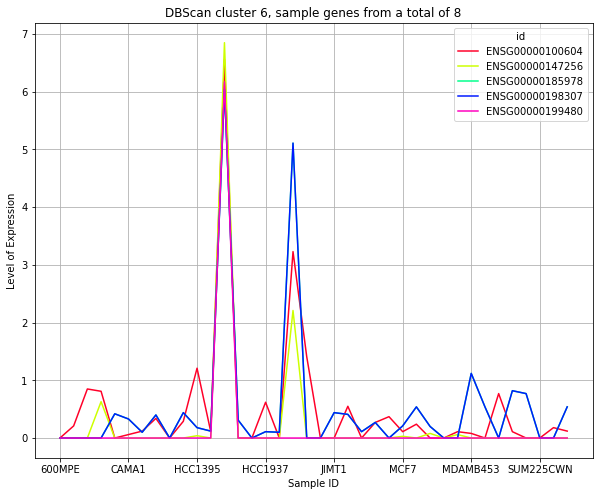

In [ ]:
#create an empty list
corrlist_DB = []


#loop for DBScan clusters
for i in range(0, n_clusters_DB): 
  
  #select only one cluster at a time
  Clusteri = df_DBScan[df_DBScan['DBScan'] == i]
  Clusteri = Clusteri.drop(['DBScan'], axis=1)
  Clusteri.head()
  n = len(Clusteri)

  if n < 10:
      ClusteriX = Clusteri.head(5)
  else:
      ClusteriX = Clusteri.head(10)
                
  ClusteriX.T.plot(colormap='gist_rainbow', 
                   figsize=(10,8),
                   title='DBScan cluster %s, sample genes from a total of %s' % (i, n),
                   sharex=False, 
                   grid=True).set(
                       ylabel='Level of Expression',
                       xlabel='Sample ID'
                   )

  print("for DBScan cluster %s, the number of genes is %s" % (i, n))

  corr = Clusteri.T.corr()
  corrmean = corr.values[np.triu_indices_from(corr.values,1)].mean()
  corrlist_DB.append([i, corrmean])

  #corrlist.append([i,corrmean])
  ClusteriX.iloc[:,1:38].T.plot(rot=90, use_index=False, ax=ax)

  #print(corrlist)

  

# Calculate Correlation

In [ ]:
DB_corr = pd.DataFrame(corrlist_DB, columns=["Cluster","Correlation"])

DB_corr

,Cluster,Correlation
0,0,0.066466
1,1,0.919367
2,2,0.531646
3,3,0.750549
4,4,0.604226
5,5,1.000000
6,6,0.896401


[Text(0, 0.5, 'Mean Correlation within Cluster')]

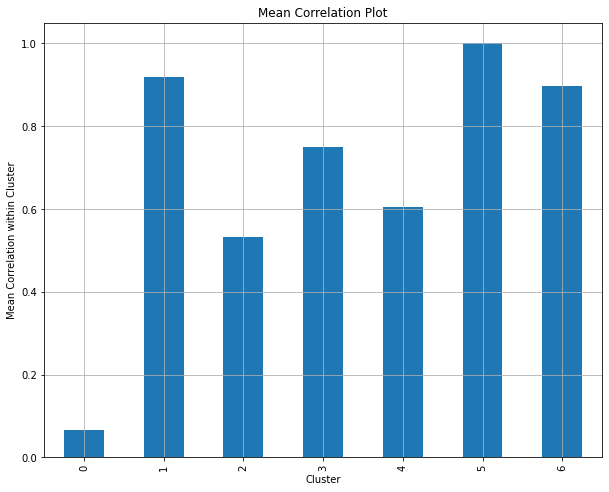

In [ ]:
DB_corr.plot.bar(
    x='Cluster', y='Correlation', 
    figsize=(10,8),
    title='Mean Correlation Plot', 
    legend=False,
    sharex=False, 
    grid=True).set(
        ylabel='Mean Correlation within Cluster')

# Practice:
1. try to prepare within correlation calculations and plots for OPTICS, KMEANS
2. compare clusters between themselves to see what each gene might be doing

